In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load Data
Load solver metadata, problem metadata, and solving information.

In [2]:
solver_data  = pd.read_csv('solvers.csv')
problem_data = pd.read_csv('all-instances.csv')
data         = pd.read_csv('solver-comparison-with-deletion.csv')

# solvers = set(data['solver'])
solvers = [
    'maplesat_static_none',
    'maplesat_static_rnd_rep0_force0',
    'maplesat_static_rnd_rep0_force1',
    'maplesat_static_rnd_rep1_force0',
    'maplesat_static_rnd_rep1_force1',
    'maplesat_static_sub_rep0_force0',
    'maplesat_static_sub_rep0_force1',
    'maplesat_static_sub_rep1_force0',
    'maplesat_static_sub_rep1_force1'
]

# Data Cleaning
If the instance could not be solved, set its solving time equal to the maximum value.

Drop any instances for which data could not be collected or for which solving time is 0.

In [3]:
max_cpu_time = 5000
data['cpu_time'] = data.apply(lambda row: max_cpu_time if row['satisfiability'] == 'INDETERMINATE' else row['cpu_time'], axis=1)
data['cpu_time'] = data['cpu_time'].apply(lambda val: val if val else np.nan)
data = data.dropna()

data        ['problem'      ] = data        ['problem']      .apply(lambda val: val.strip())
problem_data['instance_path'] = problem_data['instance_path'].apply(lambda val: val.strip())

# Compute normalized statistics

In [4]:
data['adjusted_time'] = data.apply(lambda row: row['cpu_time'    ] - row['er_time'      ], axis=1)
data['overhead_frac'] = data.apply(lambda row: row['er_time'     ] / row['cpu_time'     ], axis=1)
data['conf_per_dec' ] = data.apply(lambda row: row['conflicts'   ] / row['decisions'    ], axis=1)
data['prop_per_dec' ] = data.apply(lambda row: row['propagations'] / row['decisions'    ], axis=1)
data['conf_per_sec' ] = data.apply(lambda row: row['conflicts'   ] / row['adjusted_time'], axis=1)
data['avg_lbd'      ] = data.apply(lambda row: row['total_lbd'   ] / row['conflicts'    ] if row['conflicts'] else np.nan, axis=1)
data['ev_conf_frac' ] = data.apply(lambda row: row['ev_conflicts'] / row['conflicts'    ] if row['conflicts'] else np.nan, axis=1)
data['conf_per_ev'  ] = data.apply(lambda row: row['ev_conflicts'] / row['num_ev'       ] if row['num_ev'   ] else np.nan, axis=1)

In [5]:
x = problem_data.set_index('instance_path')
data['category'] = data['problem'].apply(lambda val: x.loc[val, ['category']])

# Explanation of Columns
Here, we list the statistics which are captured from running the solvers. Normalized statistics are computed and described later.

## Solver Configuration
* `solver`: Solver name
* `heuristic`: Heuristic used for introducing extension variables
* `sub_defn`: Substitute extension variables into clauses where their definitions occur
* `ext_freq`: How often to try introducing extension variables (minimum number of conflicts that must have occurred before searching for an extension variable)
* `window_size`: Maximum number of clauses to consider when introducing a new extension variable
* `max_new_ev`: Maximum number of new extension variables to introduce at once
* `force_branch`: Whether to force branching on new extension variables

## Problem Metadata
* `instance_path`: Absolute path to the problem instance
* `n`: Number of variables
* `m`: Number of clauses
* `category`: Problem class - can be one of:
    * `agile`
    * `crafted`
    * `crypto`
    * `random`
    * `verification`

## Base Solver Performance Statistics
* `problem`: The name of the CNF instance
* `restarts`: The total number of restarts
* `conflicts`: The total number of conflicts
* `decisions`: The total number of decisions
* `propagations`: The total number of propagations
* `conf_lits`: The total number of conflict literals
* `num_ev`: The total number of extension variables introduced
* `ev_decisions`: The total number of decisions on an extension variable
* `ev_conflicts`: The total number of times a clause containing extension variables participates in a conflict
* `ev_learnt`: The total number of times a learnt clause contains an extension variable
* `total_lbd`: The total Literal Block Distance of all learnt clauses
* `mem_used`: The total amount of memory (in MB) used for the instance
* `cpu_time`: The total amount of time (in seconds) used for the instance
* `er_time`: The total amount of time (in seconds) used for doing work related to Extended Resolution (e.g., searching for a new extension variable)
* `satisfiability`: The computed satisfiability of the formula

## Computed Solver Performance Statistics
* `adjusted_time`: CPU time - overhead associated with Extended Resolution
* `overhead_frac`: The fraction of total time taken for Extended Resolution
* `conf_per_dec`: The number of conflicts per decision (a.k.a. GLR: Global Learning Rate)
* `prop_per_dec`: The number of propagations per decision
* `conf_per_sec`: The number of conflicts per second (using adjusted time)
* `avg_lbd`: The average LBD (literal block distance) per learnt clause
* `ev_conf_frac`: The proportion of all conflicts which involve conflict clauses
* `conf_per_ev`: The average number of conflicts involving an extension clause per extension variable

In [6]:
solver_data

solver      heuristic  sub_defn  ext_freq  \
0             maplesat_static_none           none       NaN       NaN   
1  maplesat_static_rnd_rep0_force0         random       0.0    2000.0   
2  maplesat_static_rnd_rep0_force1         random       0.0    2000.0   
3  maplesat_static_rnd_rep1_force0         random       1.0    2000.0   
4  maplesat_static_rnd_rep1_force1         random       1.0    2000.0   
5  maplesat_static_sub_rep1_force1  subexpression       1.0    2000.0   
6  maplesat_static_sub_rep0_force0  subexpression       0.0    2000.0   
7  maplesat_static_sub_rep0_force1  subexpression       0.0    2000.0   
8  maplesat_static_sub_rep1_force0  subexpression       1.0    2000.0   

   window_size  max_new_ev  force_branch  
0          NaN         NaN           NaN  
1        100.0        10.0           0.0  
2        100.0        10.0           1.0  
3        100.0        10.0           0.0  
4        100.0        10.0           1.0  
5        100.0        10.0           1.0  
6        100.0        10.0           0.0  
7        100.0        10.0           1.0  
8        100.0        10.0           0.0

In [7]:
problem_data

instance_path      n      m category
0     /scratch/jt2chung/parameters_of_industiral/agi...  12055  66378    agile
1     /scratch/jt2chung/parameters_of_industiral/agi...   1787   9140    agile
2     /scratch/jt2chung/parameters_of_industiral/agi...  15298  74904    agile
3     /scratch/jt2chung/parameters_of_industiral/agi...   1785   9115    agile
4     /scratch/jt2chung/parameters_of_industiral/agi...   1790   9207    agile
...                                                 ...    ...    ...      ...
7479  /scratch/jt2chung/xMaplesatExperiments/instanc...     20     45      php
7480  /scratch/jt2chung/xMaplesatExperiments/instanc...     30     81      php
7481  /scratch/jt2chung/xMaplesatExperiments/instanc...     42    133      php
7482  /scratch/jt2chung/xMaplesatExperiments/instanc...     56    204      php
7483  /scratch/jt2chung/xMaplesatExperiments/instanc...     72    297      php

[7484 rows x 4 columns]

In [8]:
data

solver  \
0                maplesat_static_none   
1                maplesat_static_none   
2                maplesat_static_none   
3                maplesat_static_none   
4                maplesat_static_none   
...                               ...   
4648  maplesat_static_sub_rep1_force1   
4649  maplesat_static_sub_rep1_force1   
4650  maplesat_static_sub_rep1_force1   
4651  maplesat_static_sub_rep1_force1   
4652  maplesat_static_sub_rep1_force1   

                                                problem  restarts   conflicts  \
0     /scratch/jt2chung/parameters_of_industiral/agi...    2046.0   1013996.0   
1     /scratch/jt2chung/parameters_of_industiral/ran...   21314.0  14294993.0   
2     /scratch/jt2chung/parameters_of_industiral/agi...     893.0    373541.0   
3     /scratch/jt2chung/parameters_of_industiral/cry...    8190.0   4725598.0   
4     /scratch/jt2chung/parameters_of_industiral/ver...       8.0      1260.0   
...                                                 ...       ...         ...   
4648  /scratch/jt2chung/xMaplesatExperiments/instanc...       1.0        28.0   
4649  /scratch/jt2chung/xMaplesatExperiments/instanc...       2.0       159.0   
4650  /scratch/jt2chung/xMaplesatExperiments/instanc...       7.0       910.0   
4651  /scratch/jt2chung/xMaplesatExperiments/instanc...      31.0      6625.0   
4652  /scratch/jt2chung/xMaplesatExperiments/instanc...     125.0     34559.0   

       decisions  propagations     conf_lits  num_ev  ev_decisions  \
0      1708997.0  1.252339e+09  7.978175e+07     0.0           0.0   
1     55004789.0  5.370689e+09  7.484596e+09     0.0           0.0   
2       676541.0  3.379843e+08  1.960917e+07     0.0           0.0   
3      8485476.0  9.604098e+09  8.215472e+08     0.0           0.0   
4         2563.0  5.105510e+05  1.886100e+04     0.0           0.0   
...          ...           ...           ...     ...           ...   
4648        36.0  2.780000e+02  1.010000e+02     0.0           0.0   
4649       209.0  1.806000e+03  1.129000e+03     0.0           0.0   
4650      1122.0  1.144800e+04  9.626000e+03     0.0           0.0   
4651      7664.0  9.210300e+04  9.511600e+04     0.0           0.0   
4652     38785.0  4.489720e+05  6.328140e+05     0.0           0.0   

      ev_conflicts  ...  satisfiability  adjusted_time  overhead_frac  \
0              0.0  ...     SATISFIABLE     317.132547   1.428423e-06   
1              0.0  ...   INDETERMINATE    4999.998329   3.342000e-07   
2              0.0  ...     SATISFIABLE      96.307725   2.855422e-06   
3              0.0  ...   INDETERMINATE    4999.998360   3.280000e-07   
4              0.0  ...   UNSATISFIABLE       0.166655   0.000000e+00   
...            ...  ...             ...            ...            ...   
4648           0.0  ...   UNSATISFIABLE       0.000212   2.205882e-01   
4649           0.0  ...   UNSATISFIABLE       0.000317   1.701571e-01   
4650           0.0  ...   UNSATISFIABLE       0.007206   1.757035e-01   
4651           0.0  ...   UNSATISFIABLE       0.096642   1.650150e-01   
4652           0.0  ...   UNSATISFIABLE       0.634370   1.526424e-01   

      conf_per_dec  prop_per_dec   conf_per_sec     avg_lbd  ev_conf_frac  \
0         0.593328    732.791767    3197.388630   35.224975           0.0   
1         0.259886     97.640391    2858.999555  396.926337           0.0   
2         0.552134    499.576908    3878.619290   22.999805           0.0   
3         0.556904   1131.827880     945.119910   40.845005           0.0   
4         0.491611    199.200546    7560.529237    5.334921           0.0   
...            ...           ...            ...         ...           ...   
4648      0.777778      7.722222  132075.471698    2.535714           0.0   
4649      0.760766      8.641148  501577.287066    4.484277           0.0   
4650      0.811052     10.203209  126283.652512    5.658242           0.0   
4651      0.864431     12.017615   68551.975332    7.142642           0.0   


# Summarize Solver Performance

Compute percentage overhead for each ER solver variant.

overhead_frac
                                         mean
solver                                       
maplesat_static_none                 0.000005
maplesat_static_rnd_rep0_force0      0.048079
maplesat_static_rnd_rep0_force1      0.046638
maplesat_static_rnd_rep1_force0      0.302881
maplesat_static_rnd_rep1_force1      0.286761
maplesat_static_sub_rep0_force0      0.103076
maplesat_static_sub_rep0_force1      0.102526
maplesat_static_sub_rep1_force0      0.207986
maplesat_static_sub_rep1_force1      0.220245

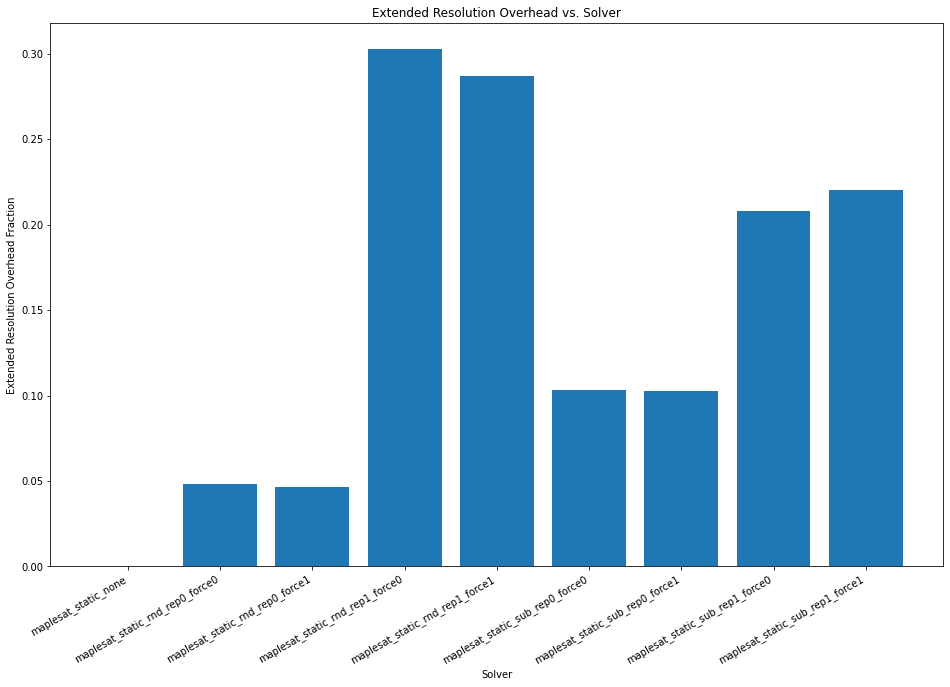

In [9]:
overhead_summary = data.groupby('solver').agg({'overhead_frac': ['mean']})
fig, ax = plt.subplots()
ax.bar(overhead_summary.index, overhead_summary['overhead_frac']['mean'])
ax.set_title(f'Extended Resolution Overhead vs. Solver')
ax.set_xlabel('Solver')
ax.set_ylabel('Extended Resolution Overhead Fraction')
fig.set_figwidth(16)
fig.set_figheight(10)

def rotateAxisLabels(ax, angle):
    for label in ax.get_xticklabels():
        label.set_rotation(angle)
        label.set_ha('right')

rotateAxisLabels(ax, 30)
overhead_summary

# Visualize Data

In [10]:
# Separate problems by variant
problem_variants = set(problem_data['category'])

def cactusForData(data, solvers, axis_y, label_y, title_label, log_scale=True):
    # Plot data
    fig, ax = plt.subplots()
    markers = ['o', '^', 's', '*', 'x', 'P', '1', 'v', '2', '<', '3', '>', '4', '8']
    for i, solver in enumerate(solvers):
        solver_series = data[data['solver']==solver].reset_index(drop=True)
        ax.plot(solver_series.index, solver_series[axis_y], label=solver, marker=markers[i])

    # Format plot
    fig.set_figwidth(16)
    fig.set_figheight(10)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
    ax.set_title(f'{label_y} vs. Benchmarks ({title_label})')
    ax.set_xlabel('Number of Benchmarks')
    ax.set_ylabel(label_y)
    if log_scale: ax.semilogy()

    # Rotate axis label names
    # rotateAxisLabels(ax, 15)

def cactusByVariant(solvers, axis_y, label_y, log_scale=True):
    sorted_data = data.sort_values(by=axis_y)
    cactusForData(sorted_data, solvers, axis_y, label_y, 'All', log_scale)
    for variant in problem_variants:
        # Plot data
        problem_series = sorted_data[sorted_data['category'] == variant]
        cactusForData(problem_series, solvers, axis_y, label_y, variant, log_scale)

## Adjusted Time (s) vs. Instance

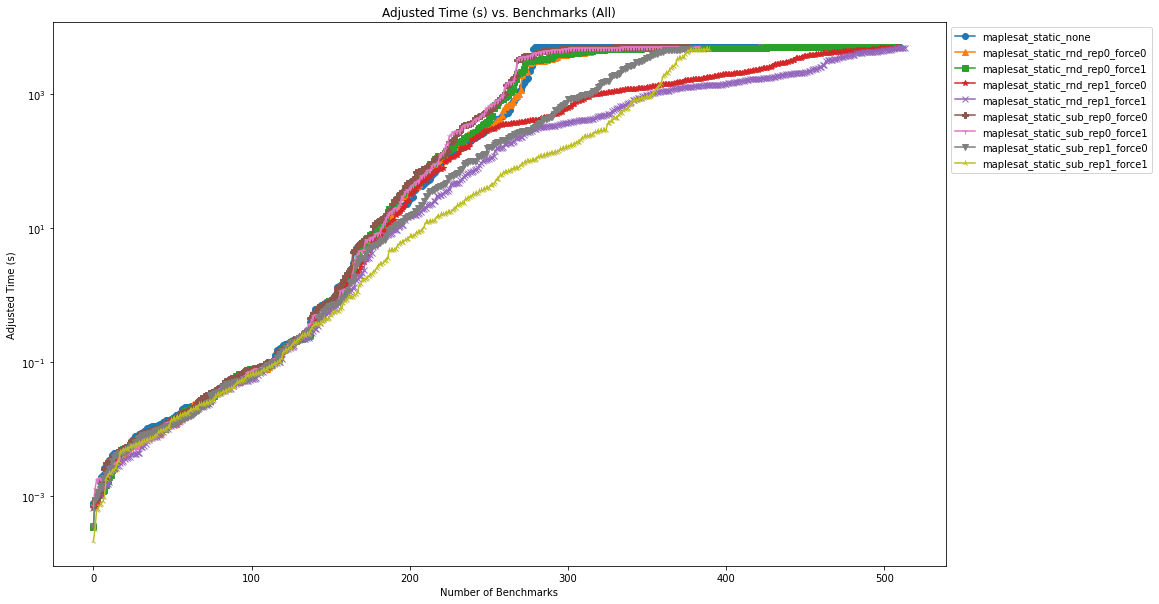

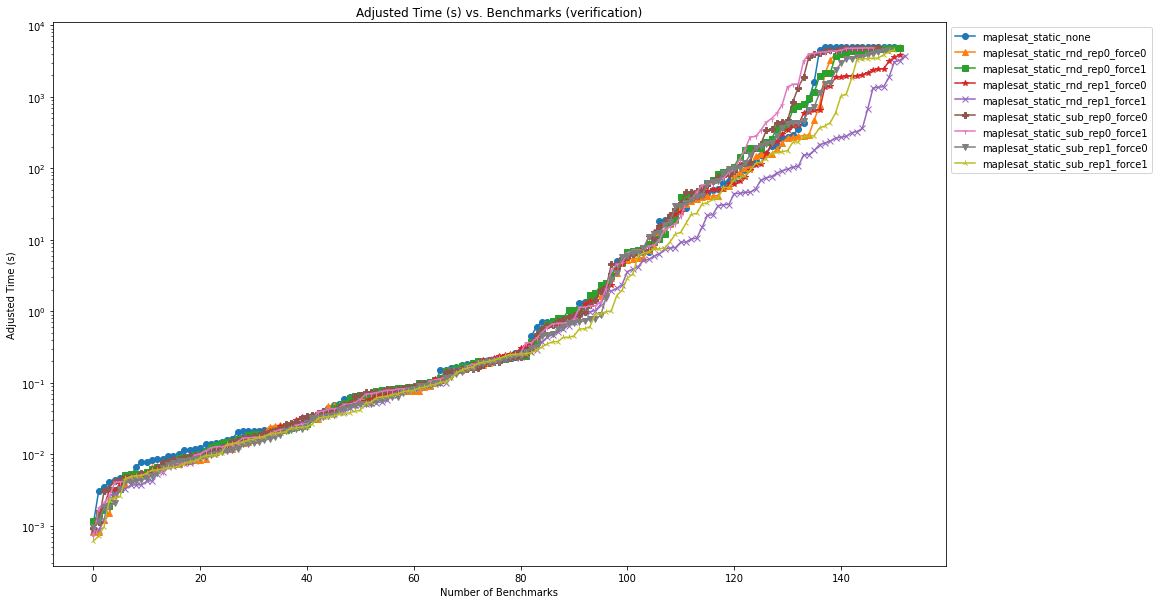

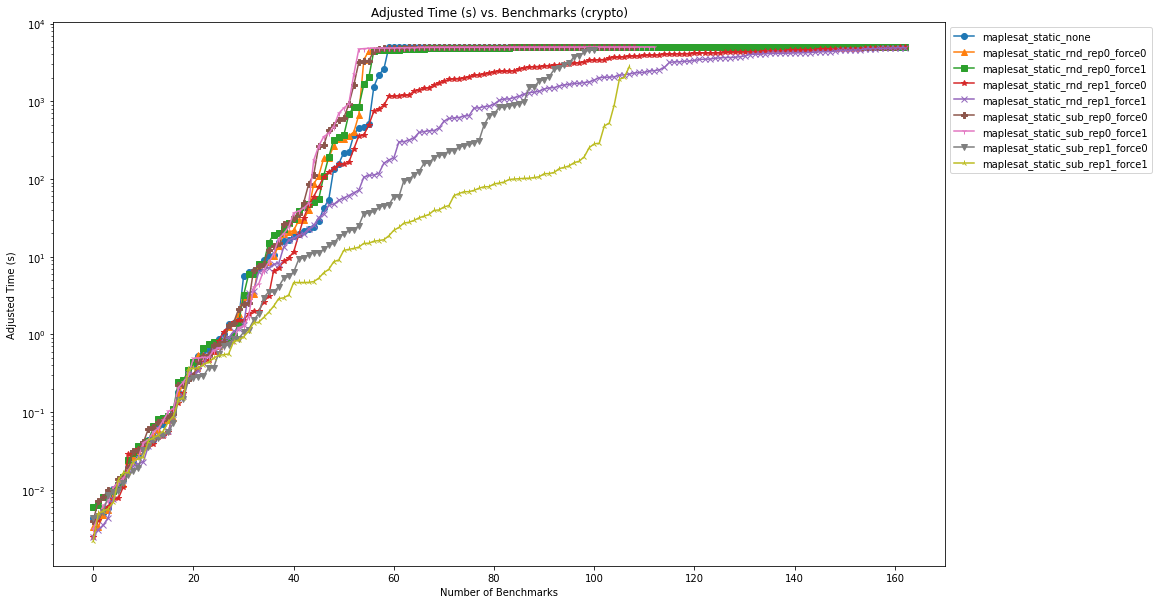

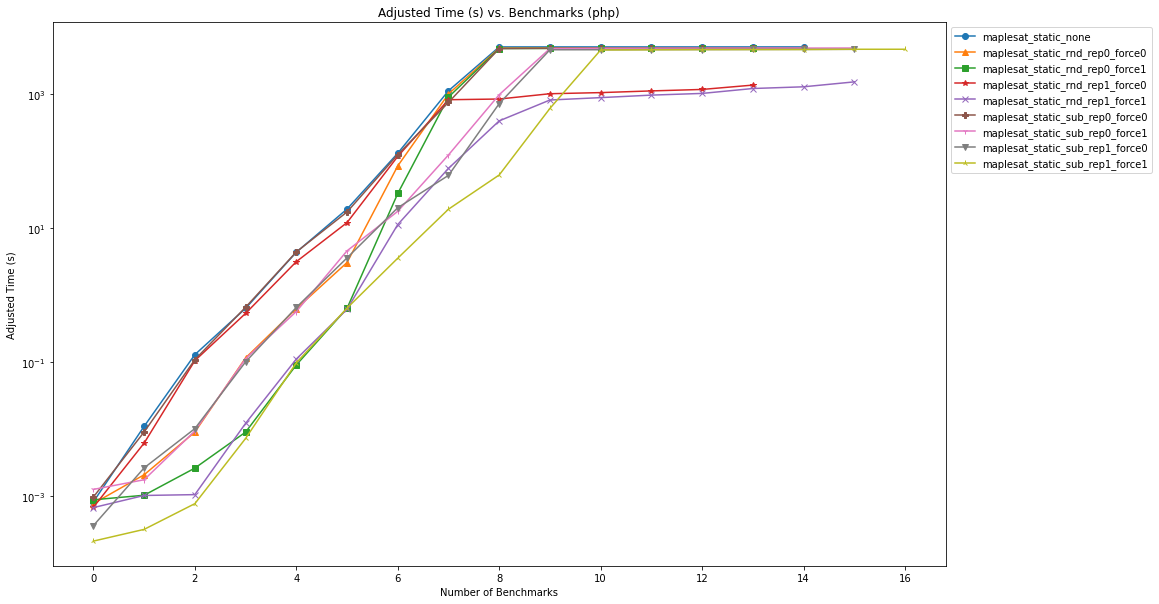

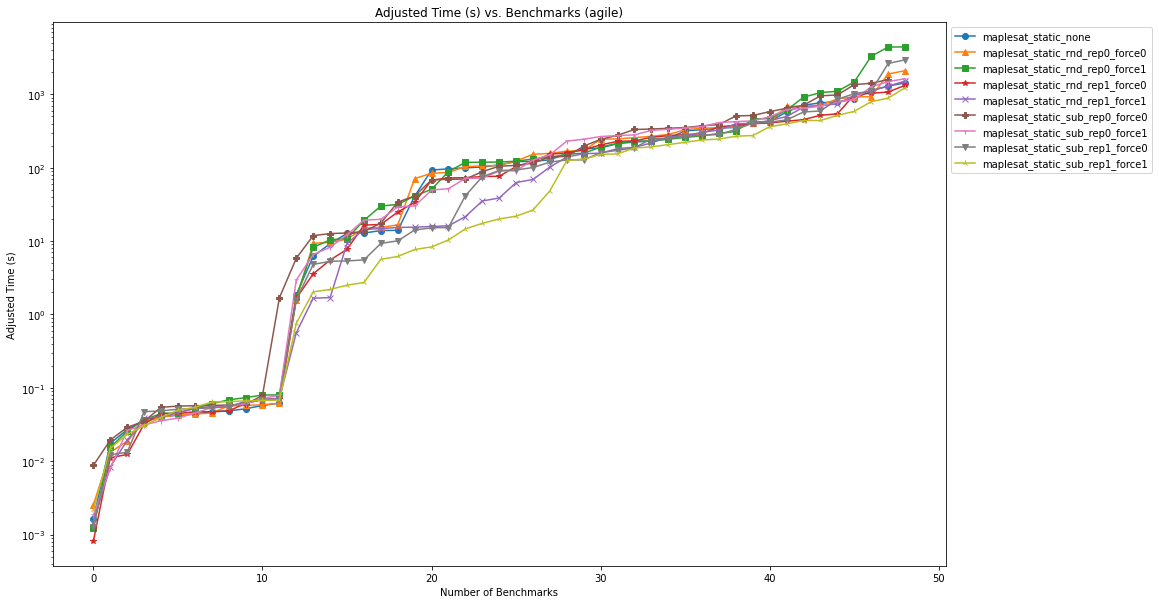

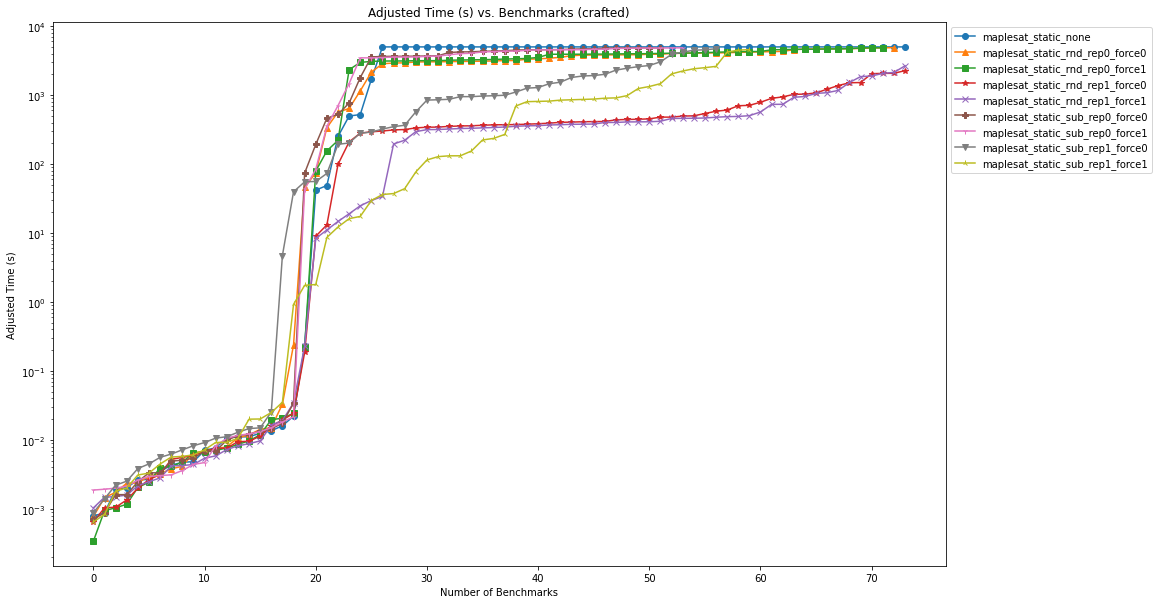

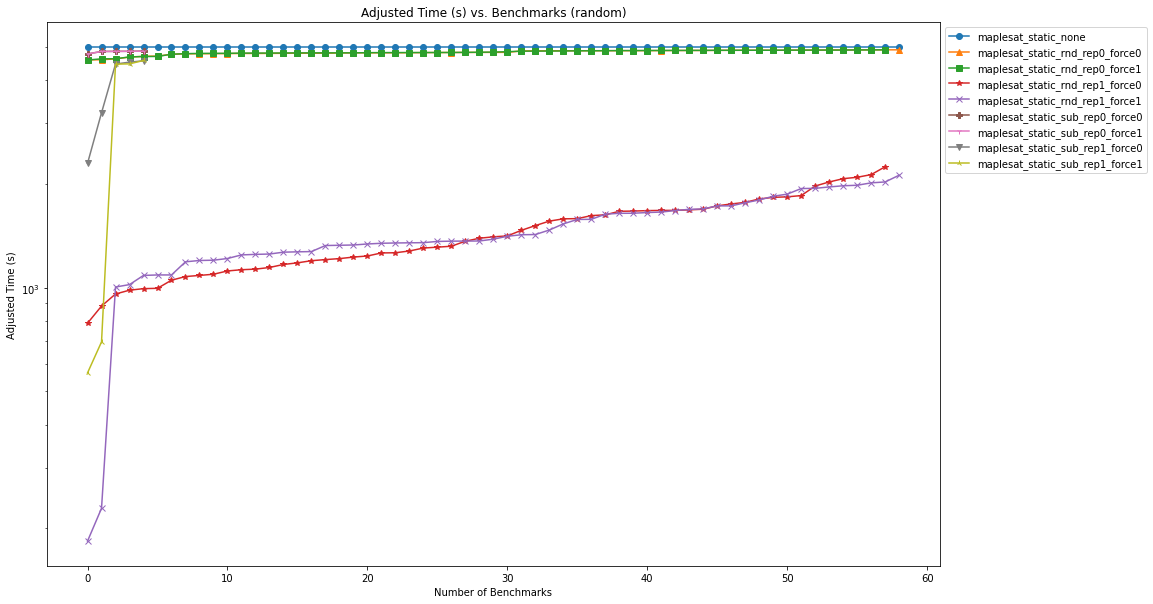

In [11]:
cactusByVariant(solvers, 'adjusted_time', 'Adjusted Time (s)')

## Total Time (s) vs. Instance

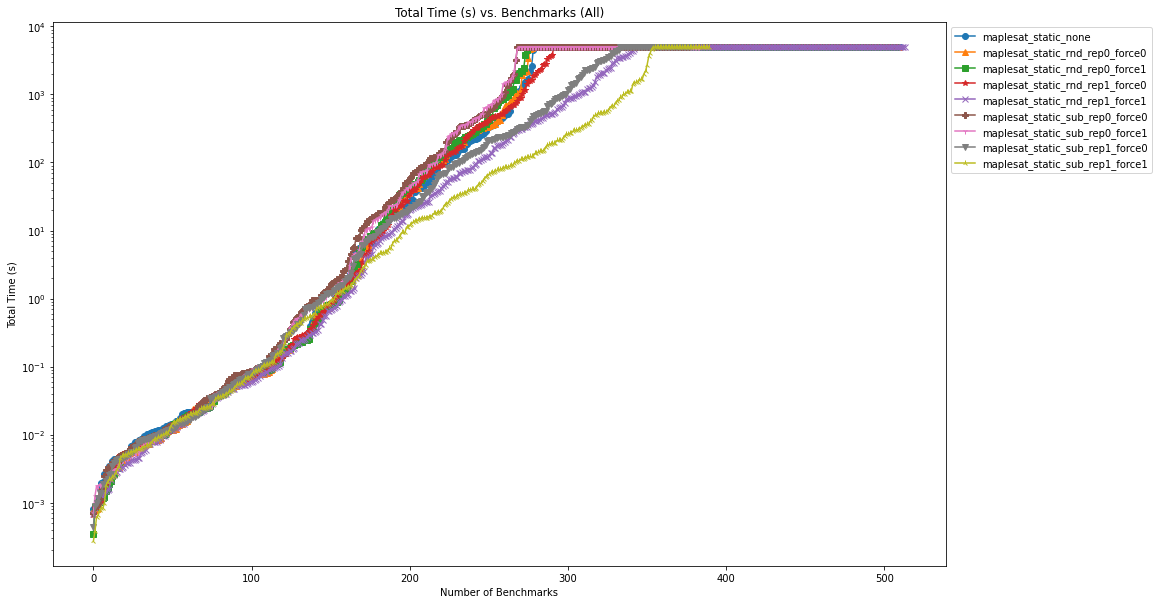

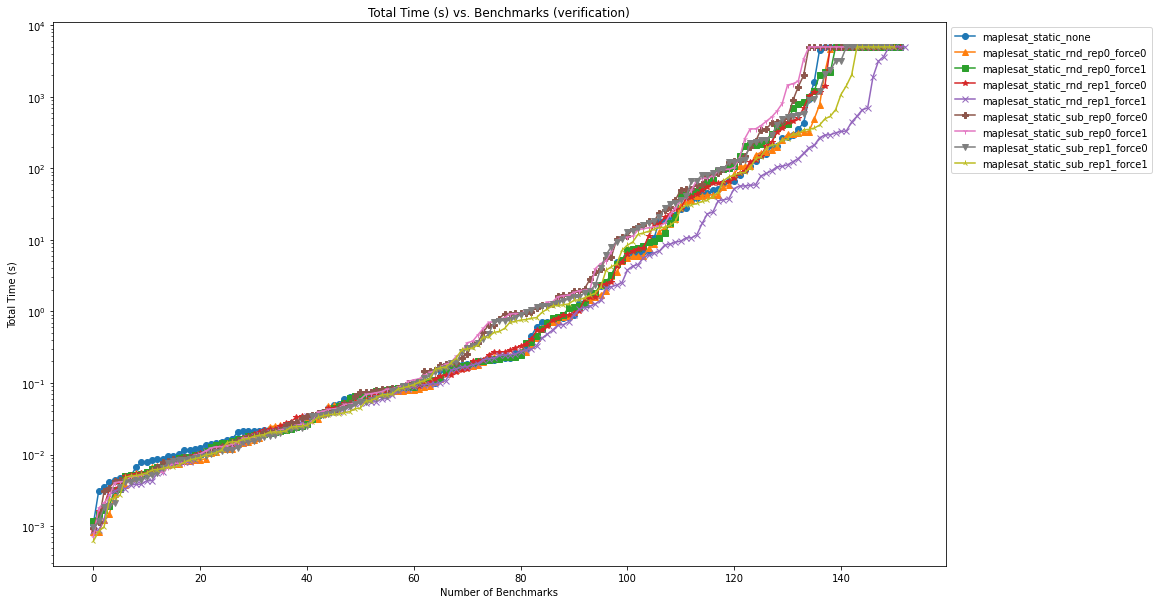

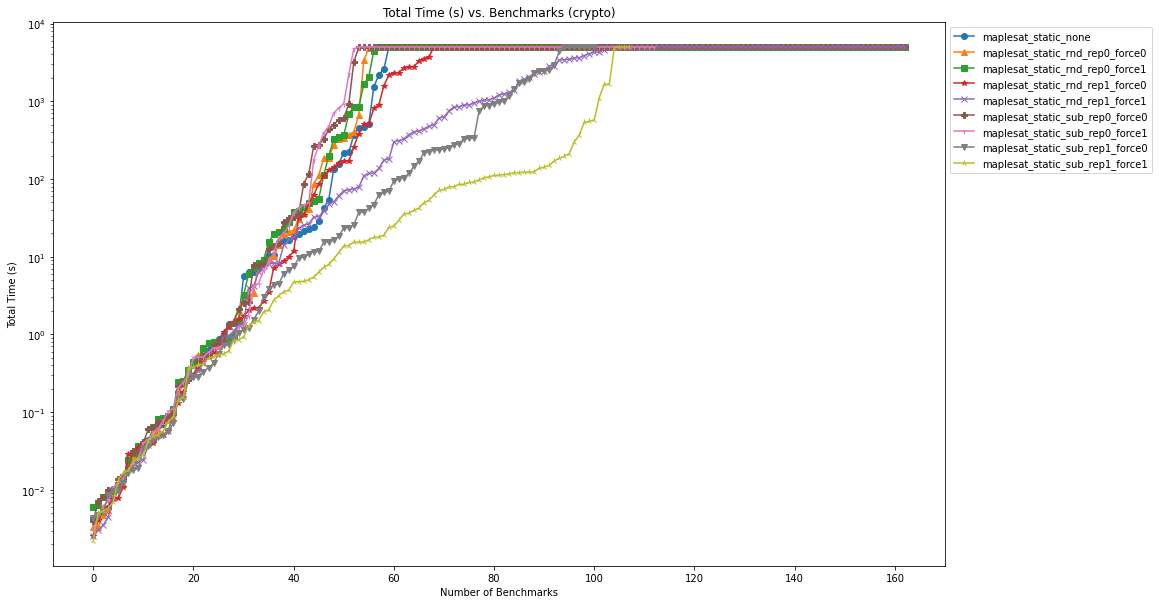

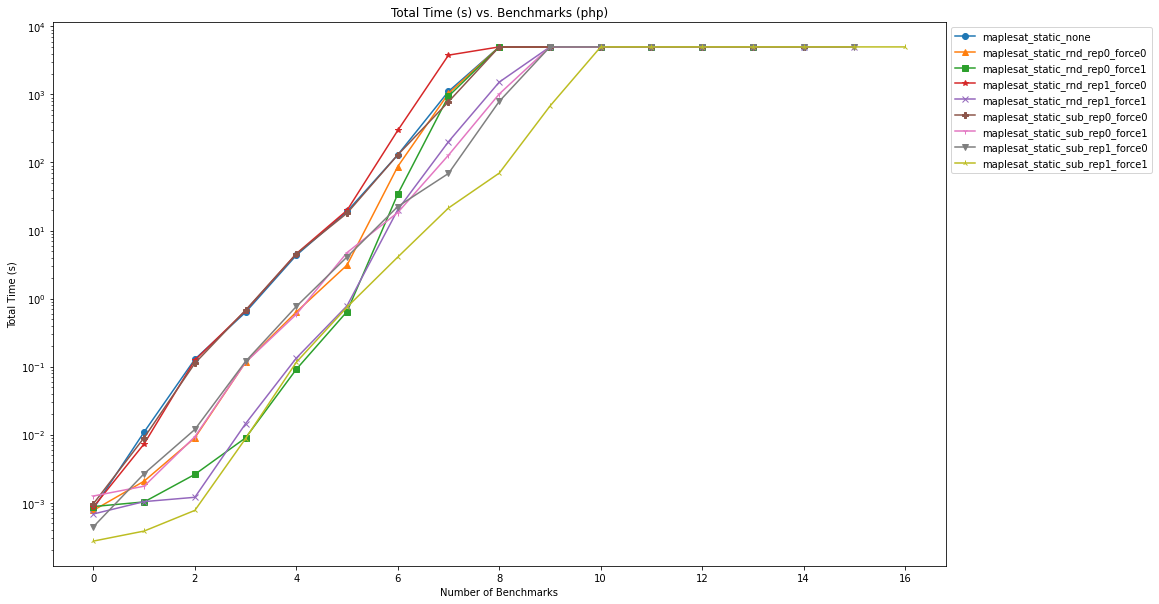

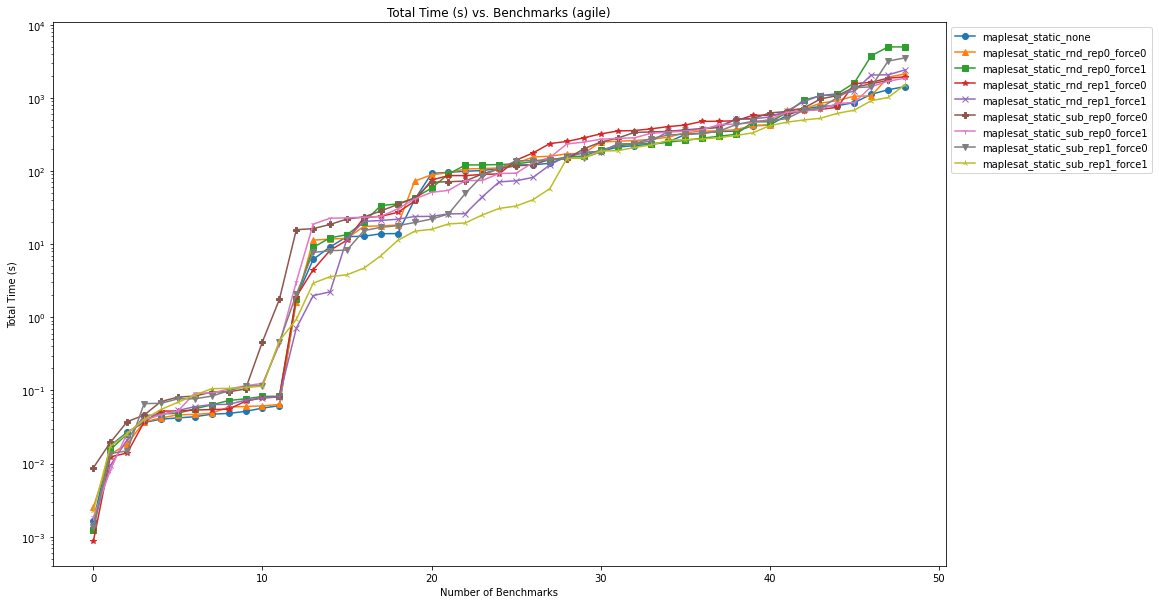

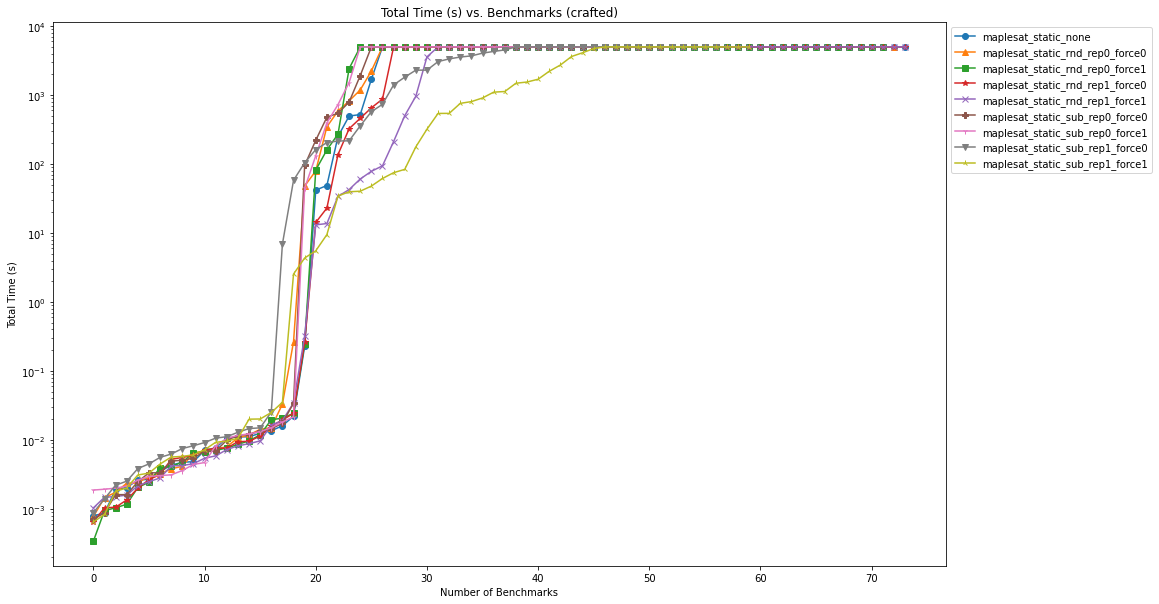

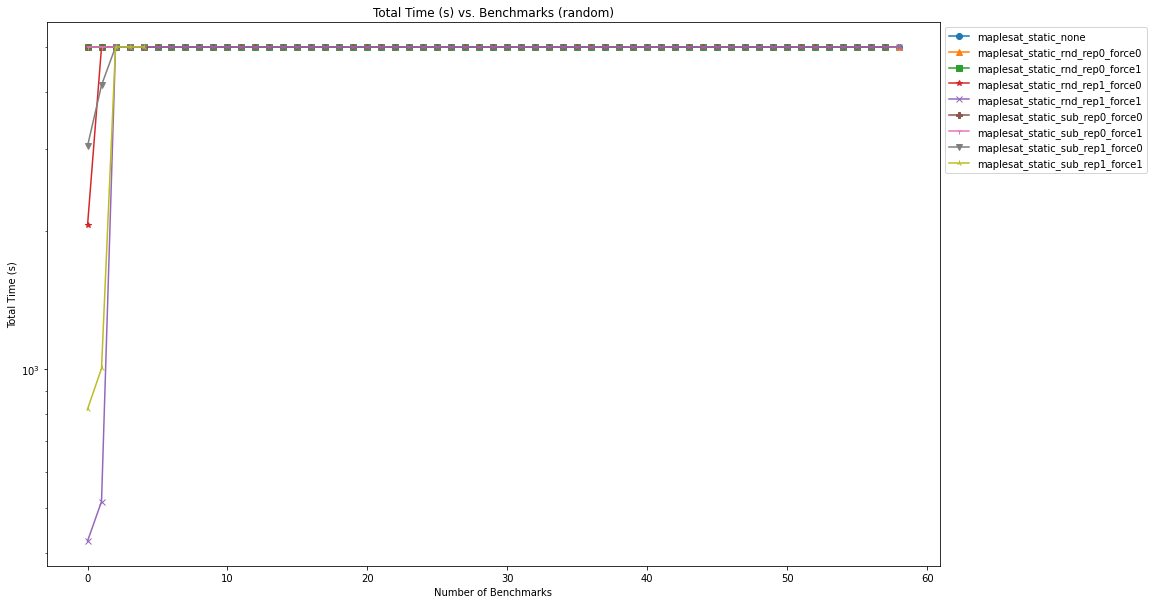

In [18]:
cactusByVariant(solvers, 'cpu_time', 'Total Time (s)')

## GLR vs. Instance

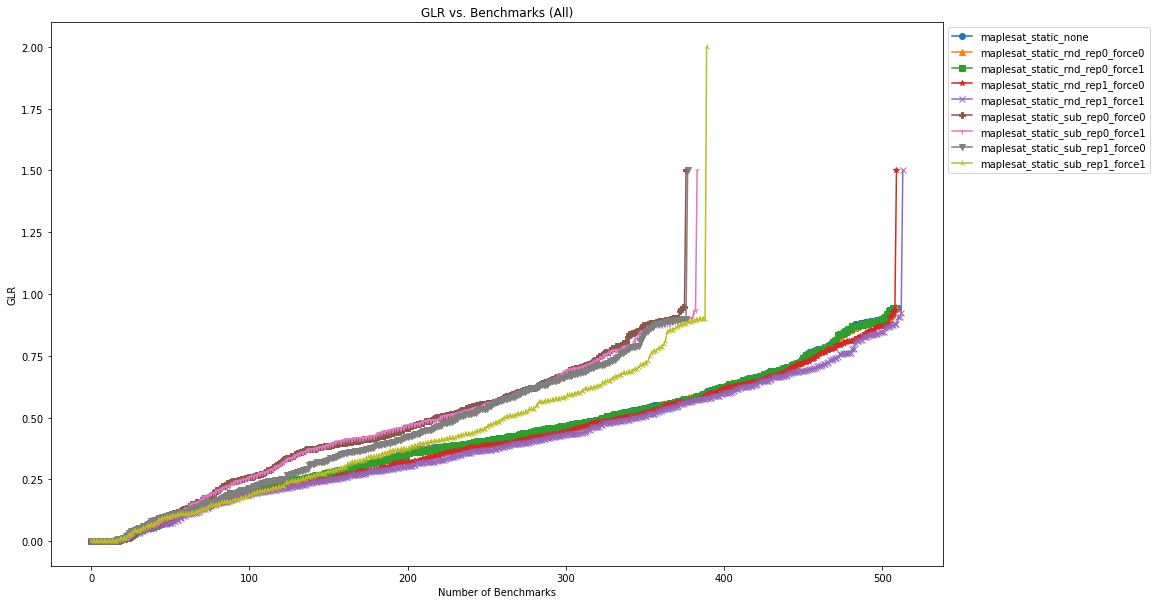

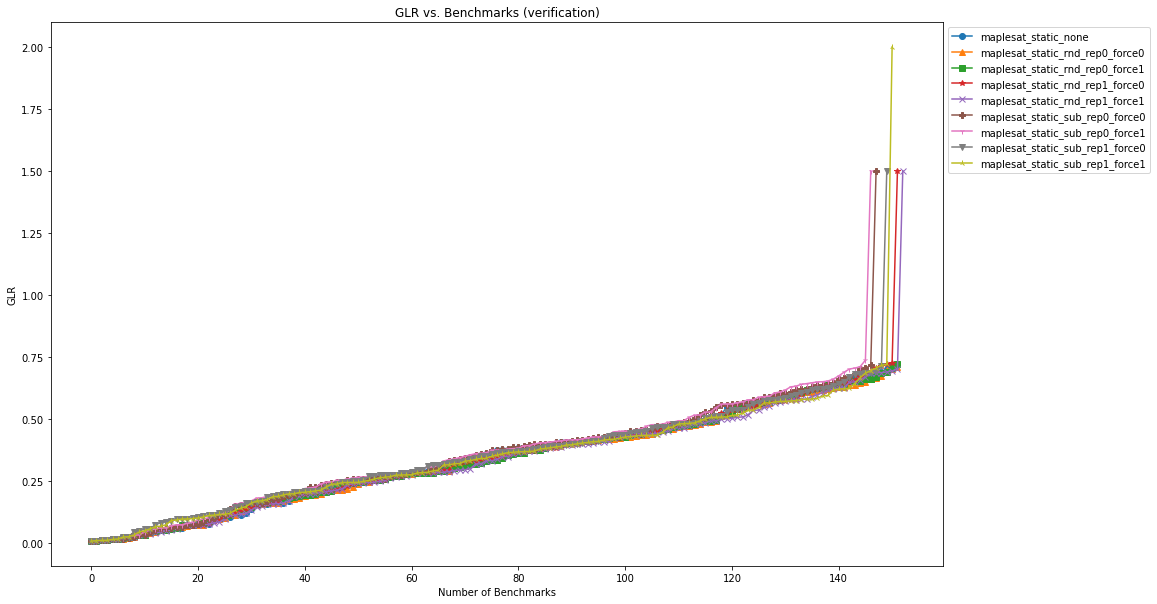

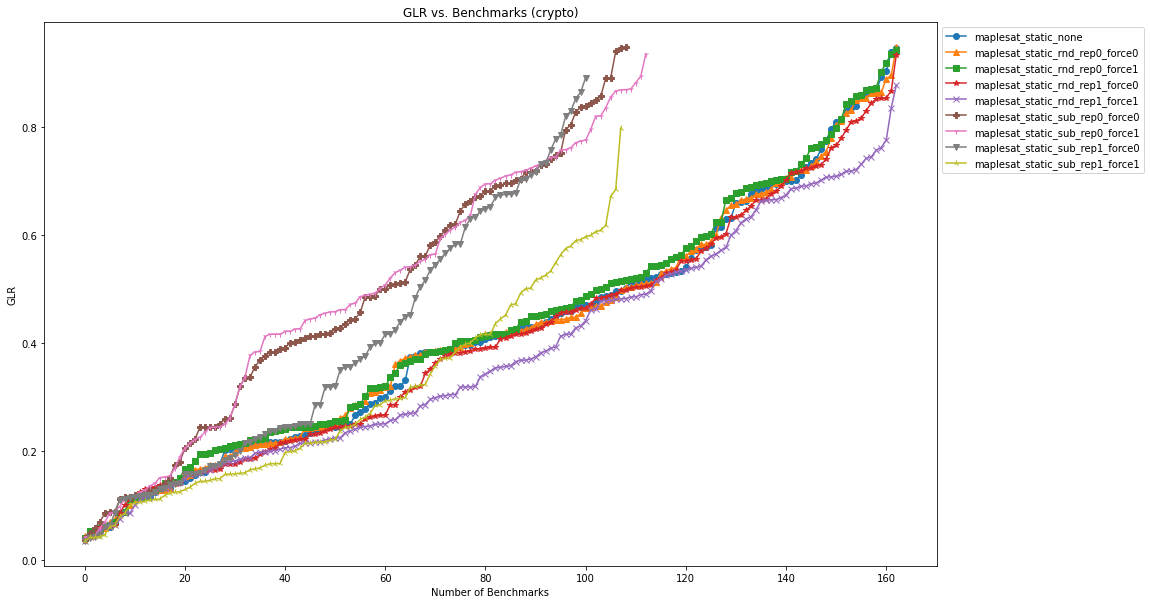

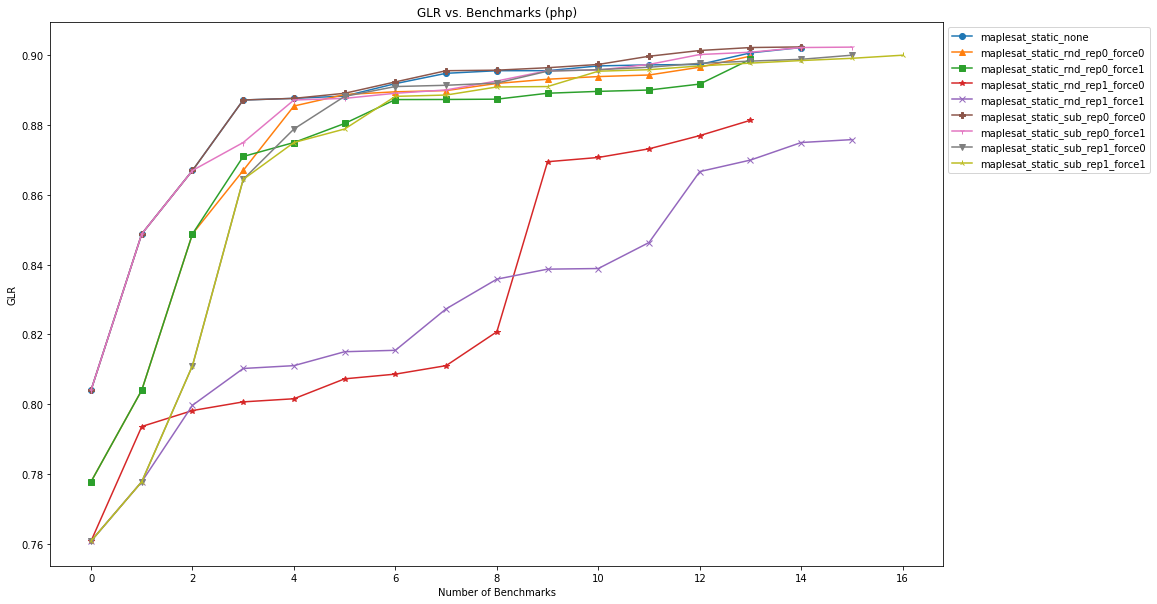

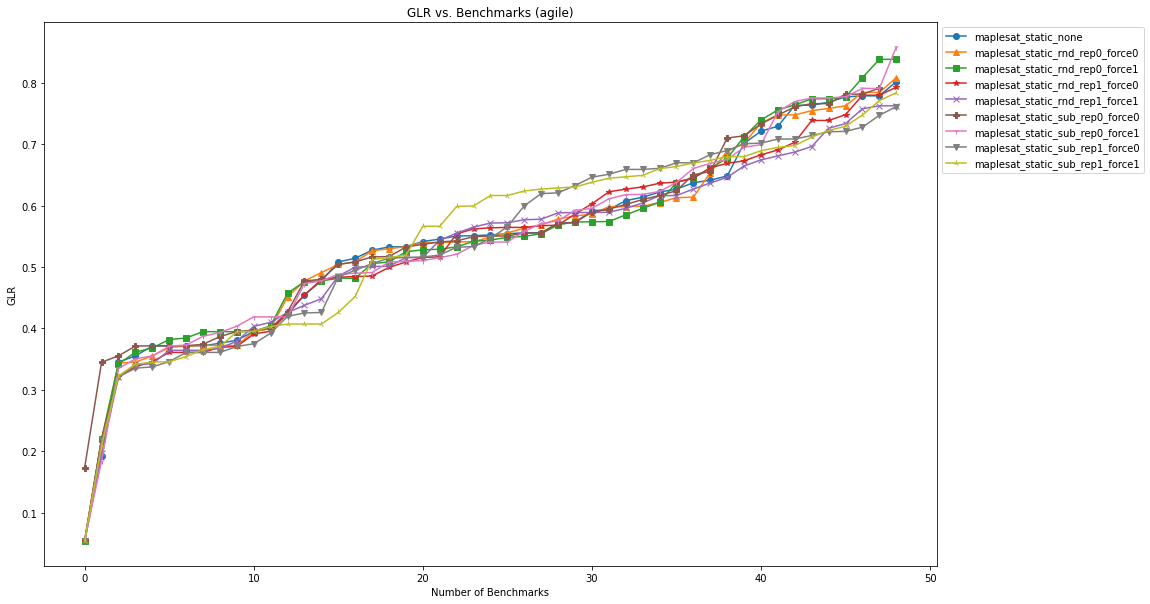

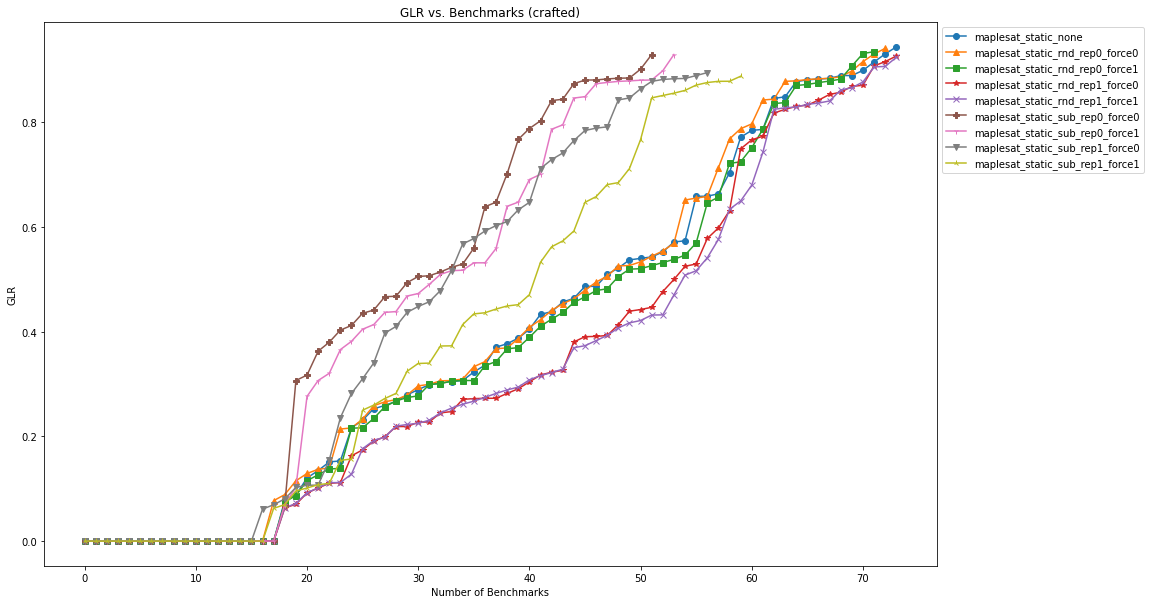

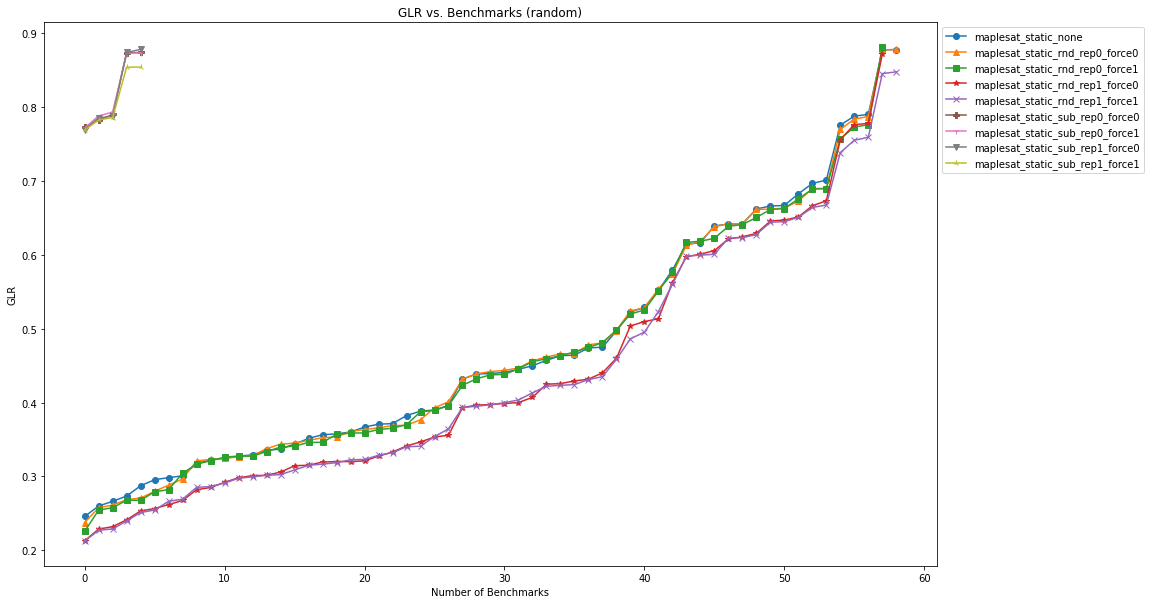

In [13]:
cactusByVariant(solvers, 'conf_per_dec', 'GLR',False)

## Average LBD vs. Instance

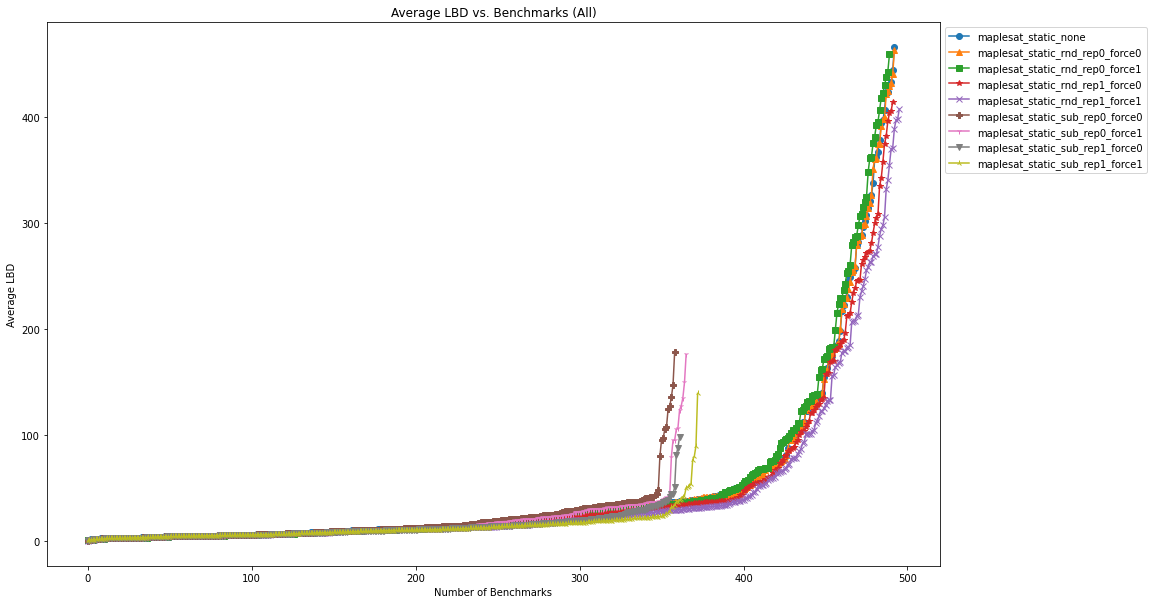

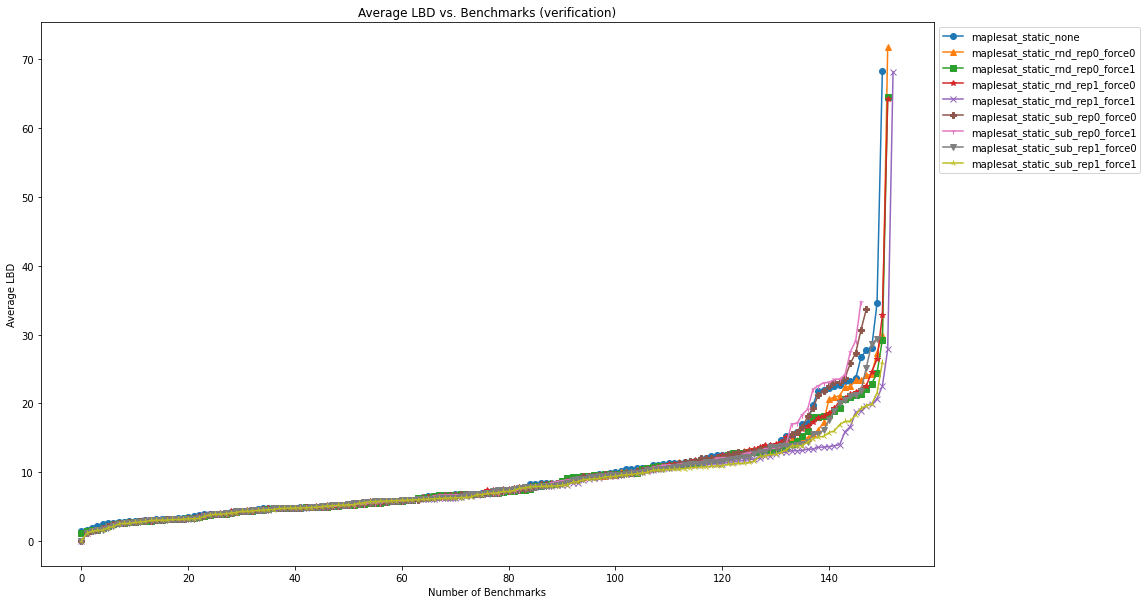

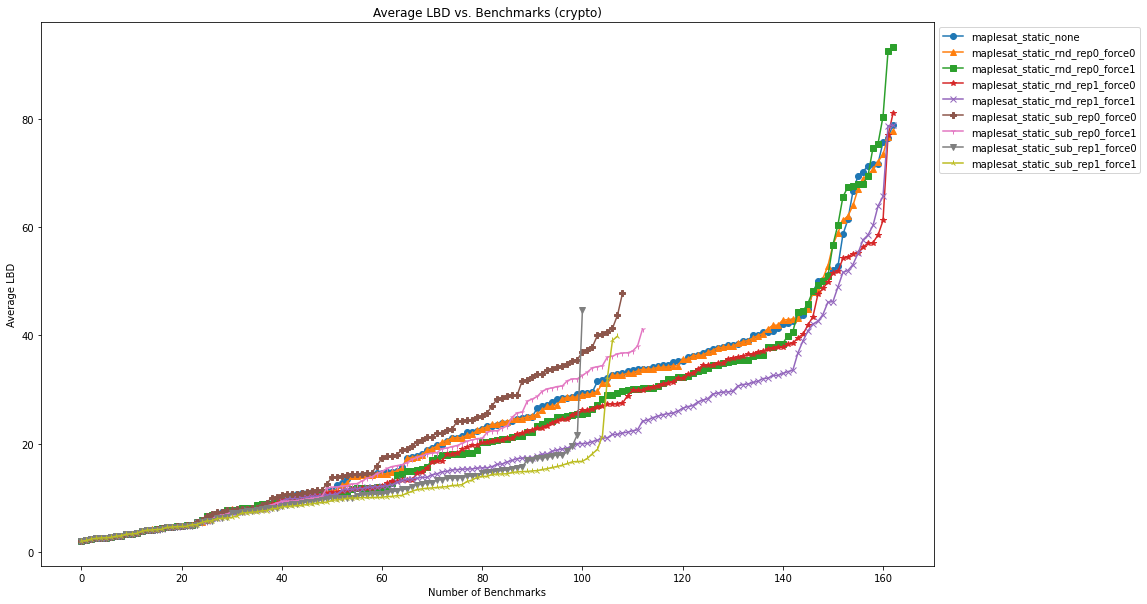

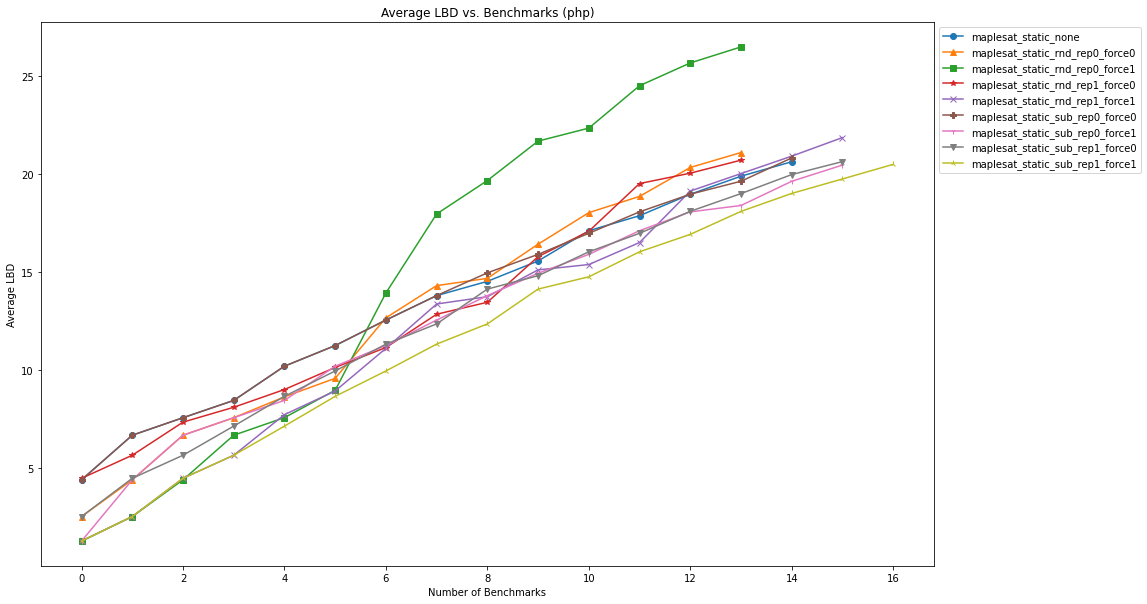

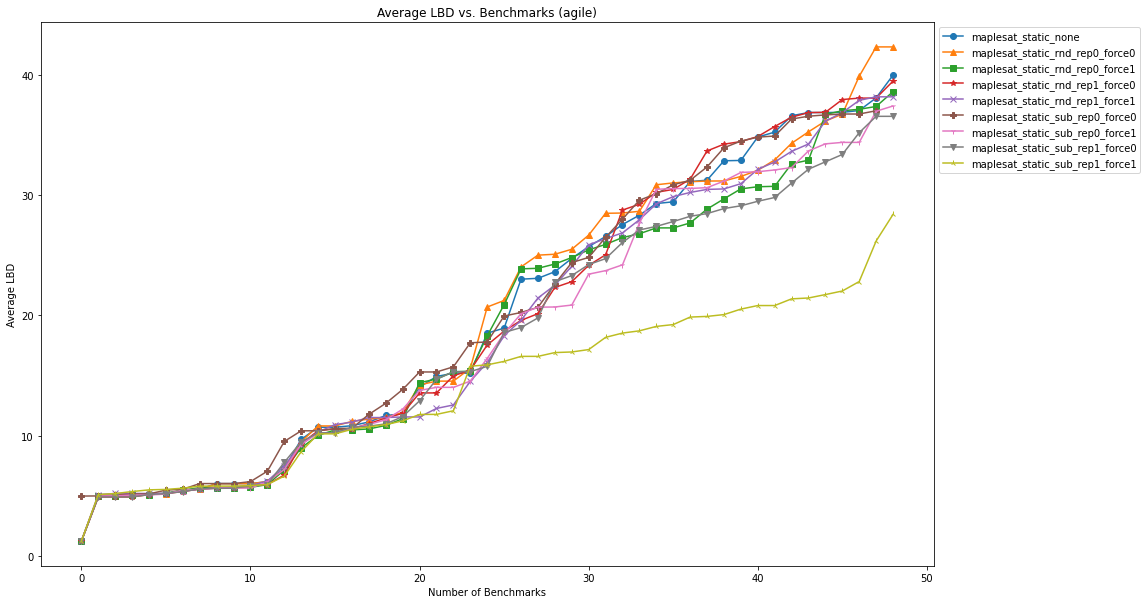

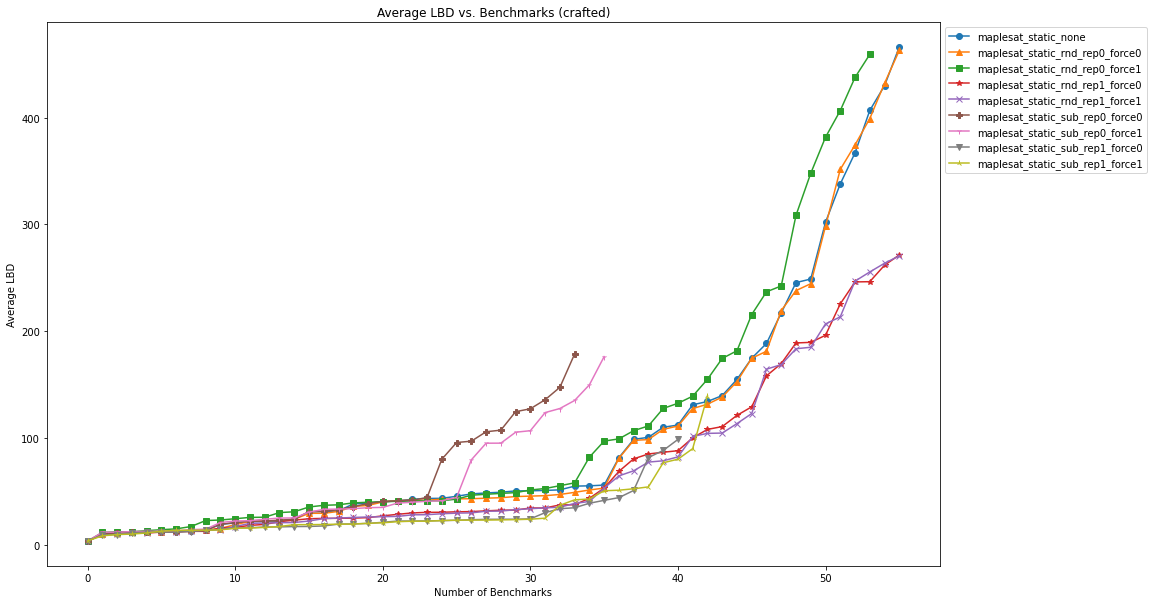

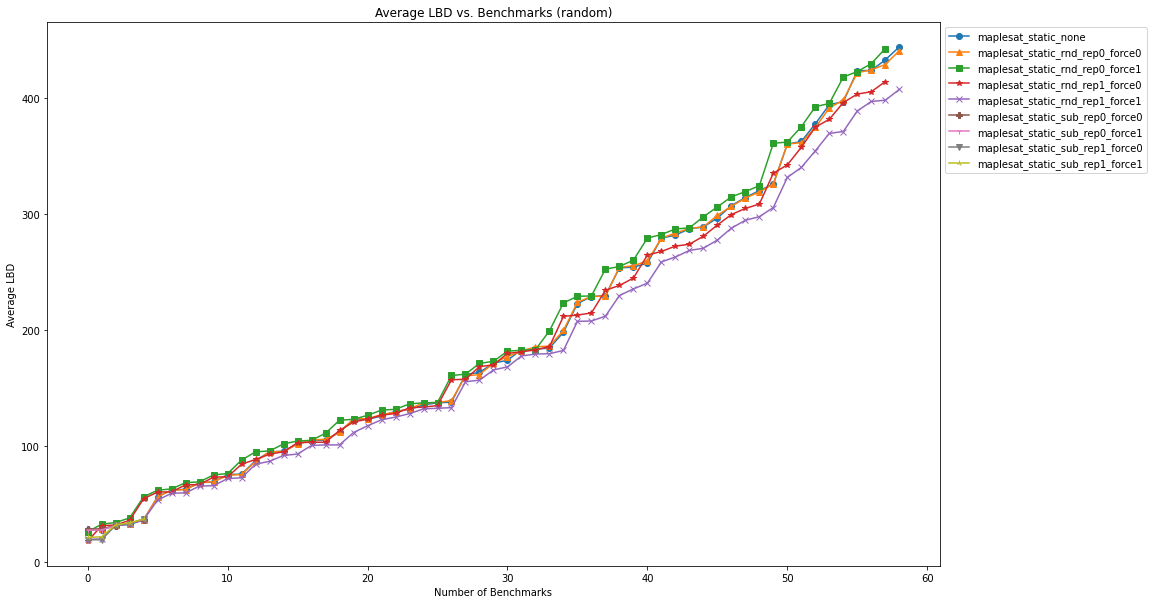

In [14]:
cactusByVariant(solvers, 'avg_lbd', 'Average LBD',False)

## Number of Extension Variables vs. Instance

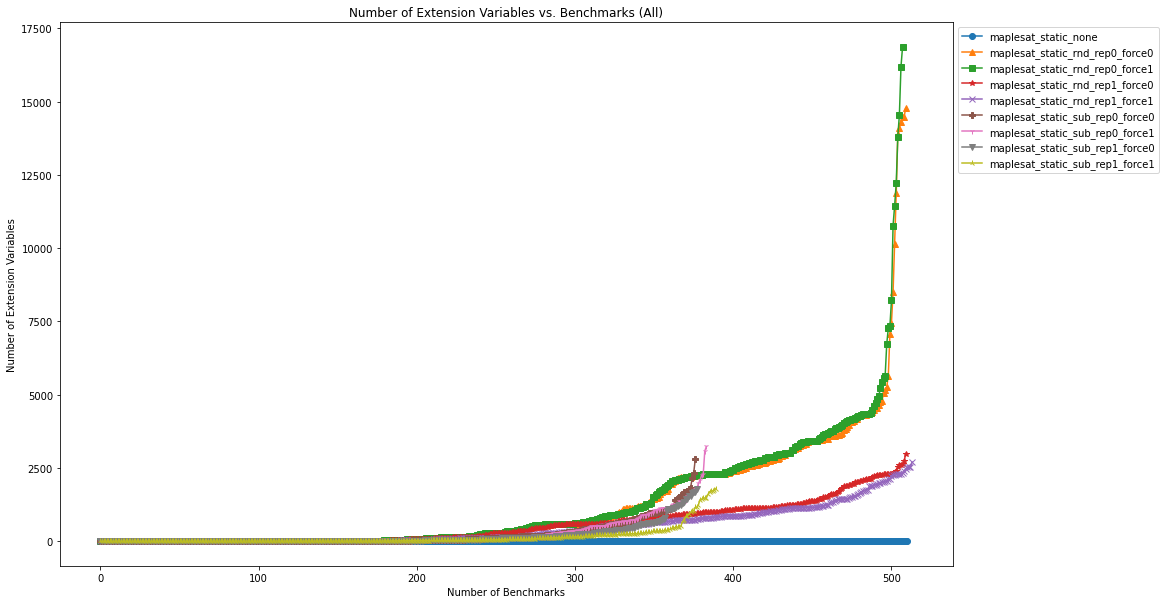

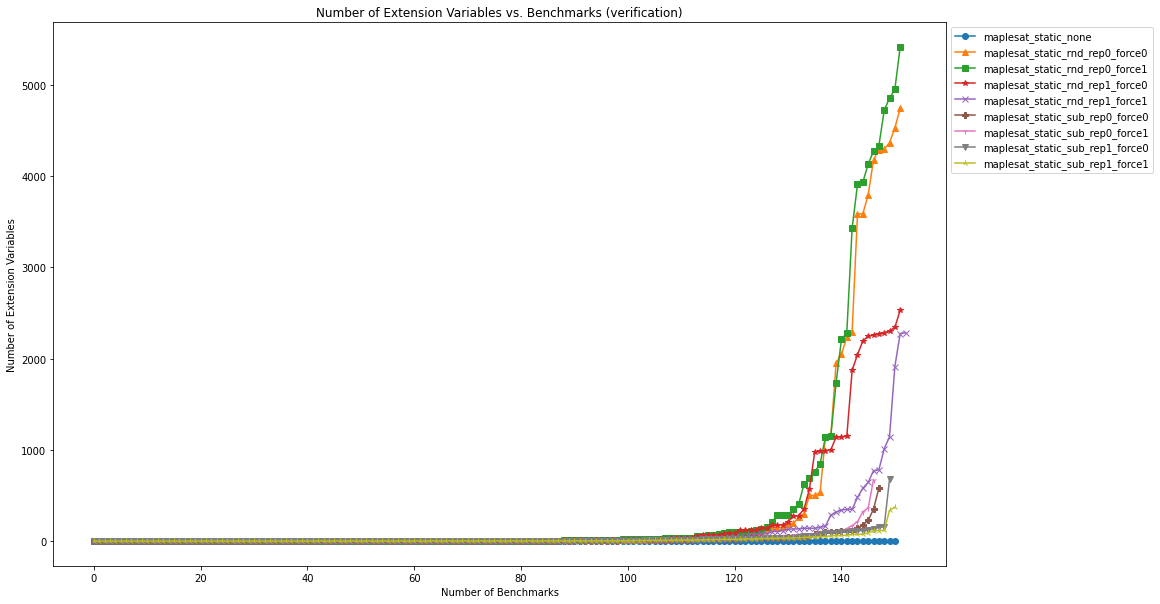

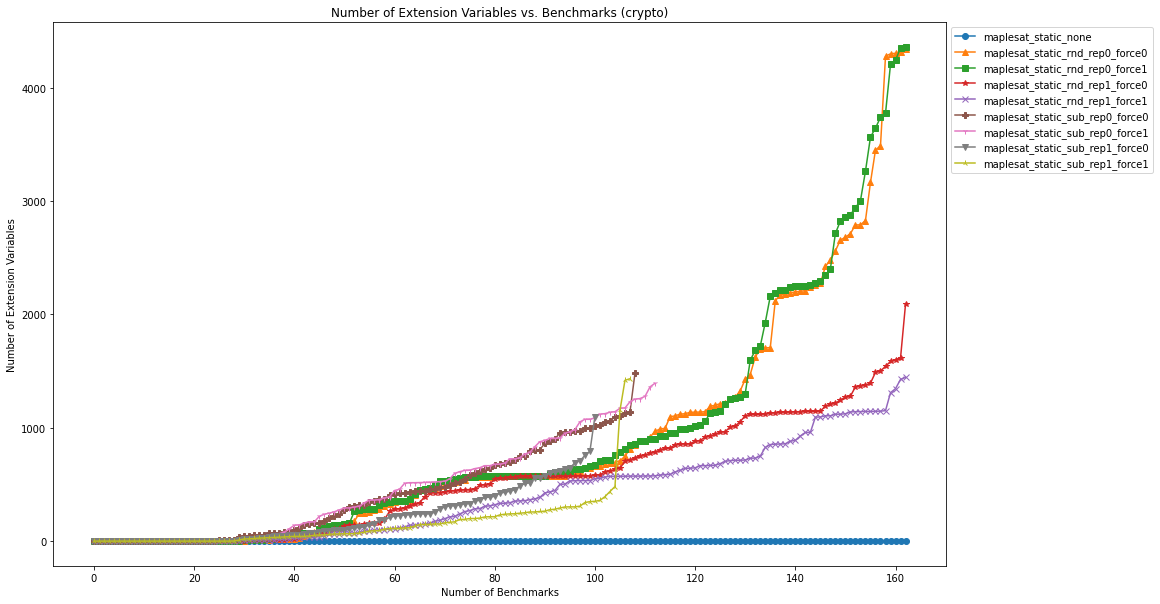

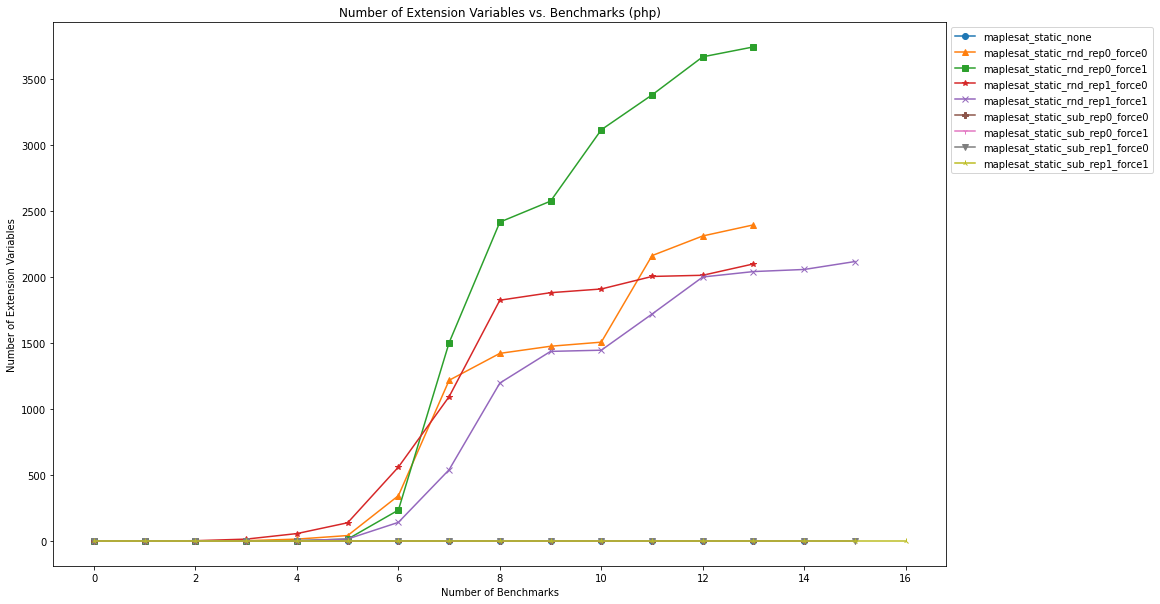

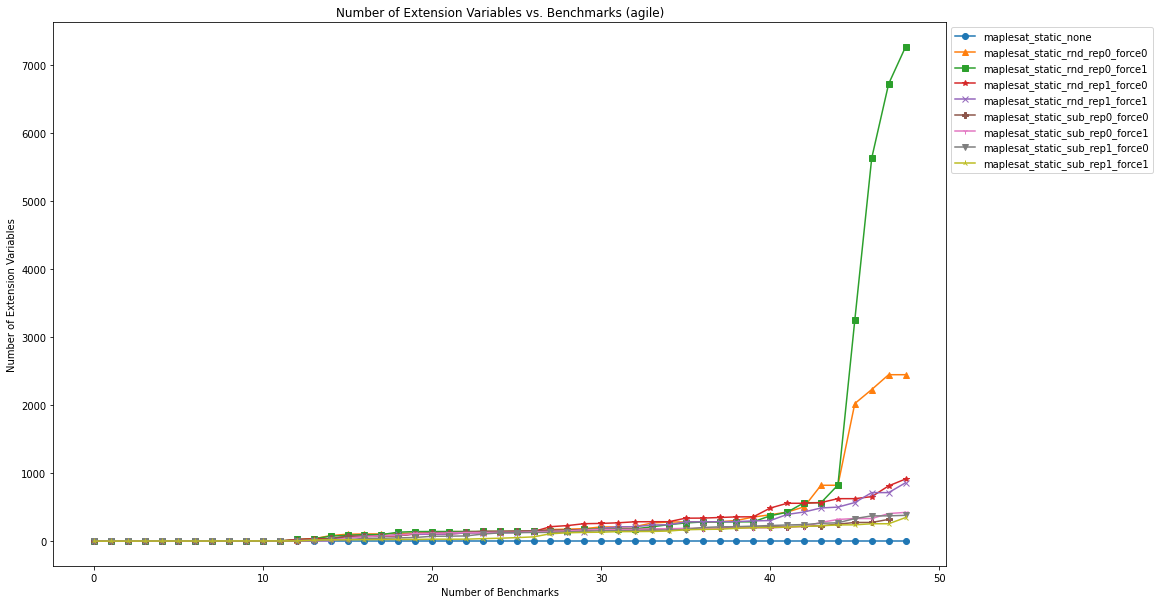

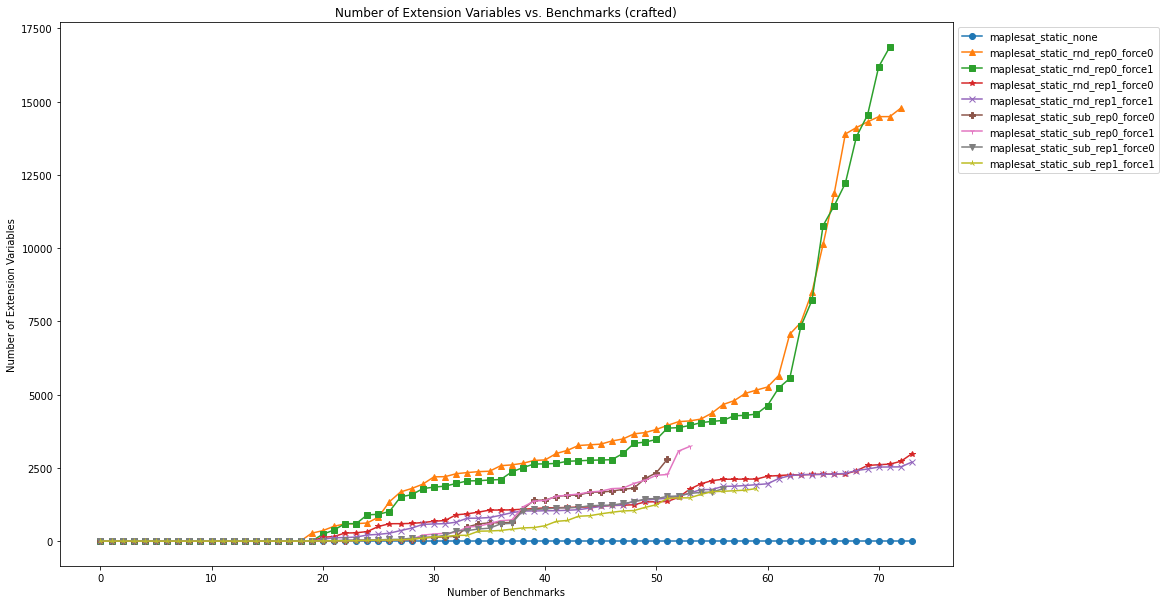

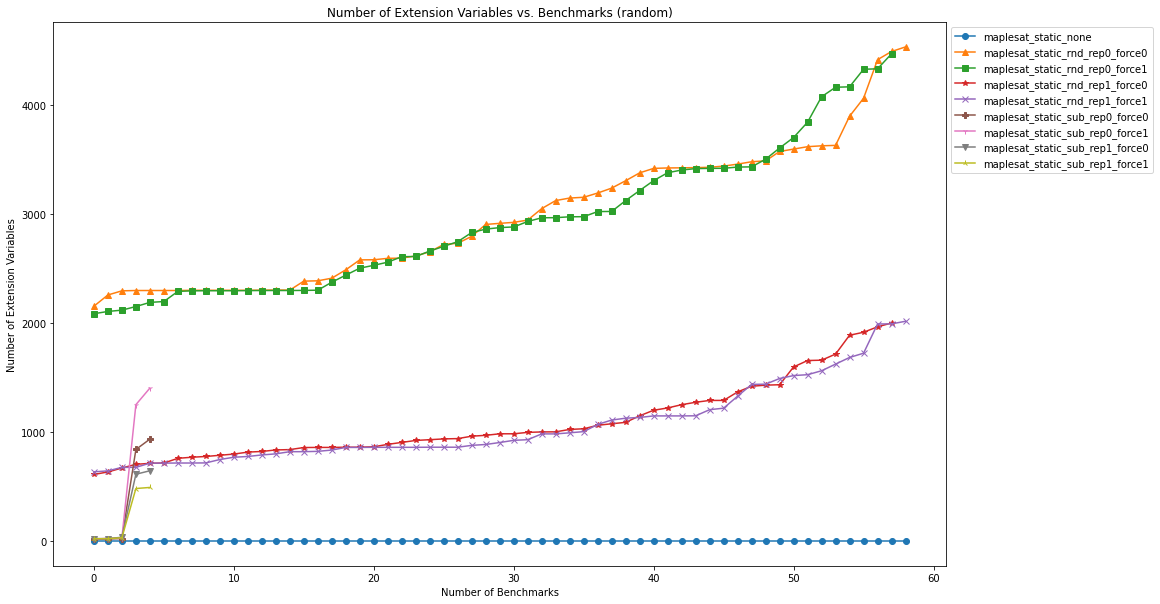

In [15]:
cactusByVariant(solvers, 'num_ev', 'Number of Extension Variables', False)

## Extension Clause Conflict Fraction vs. Instance

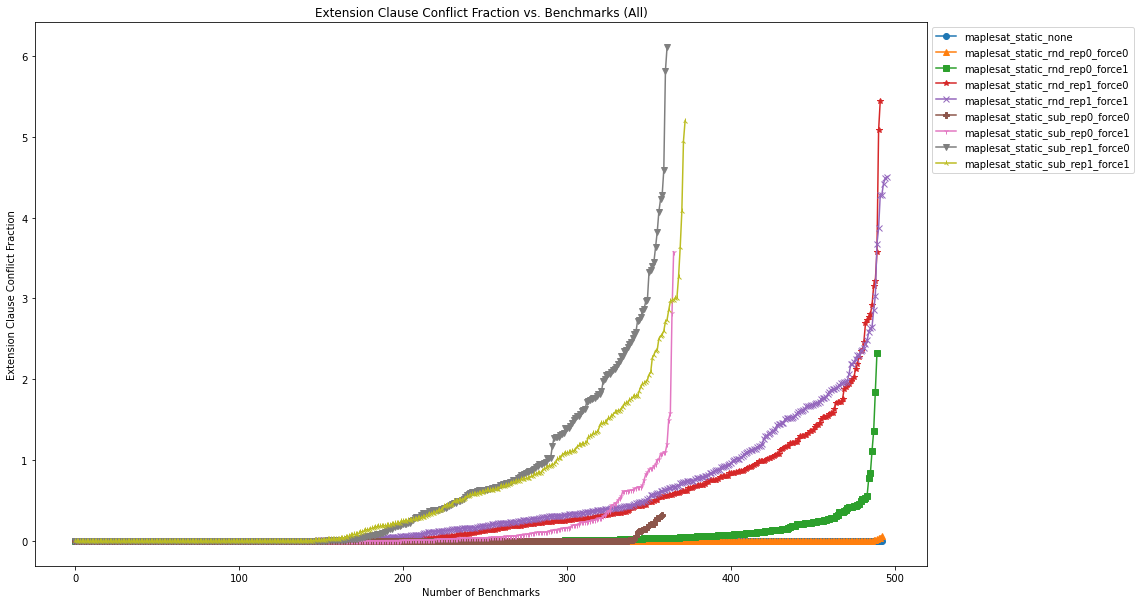

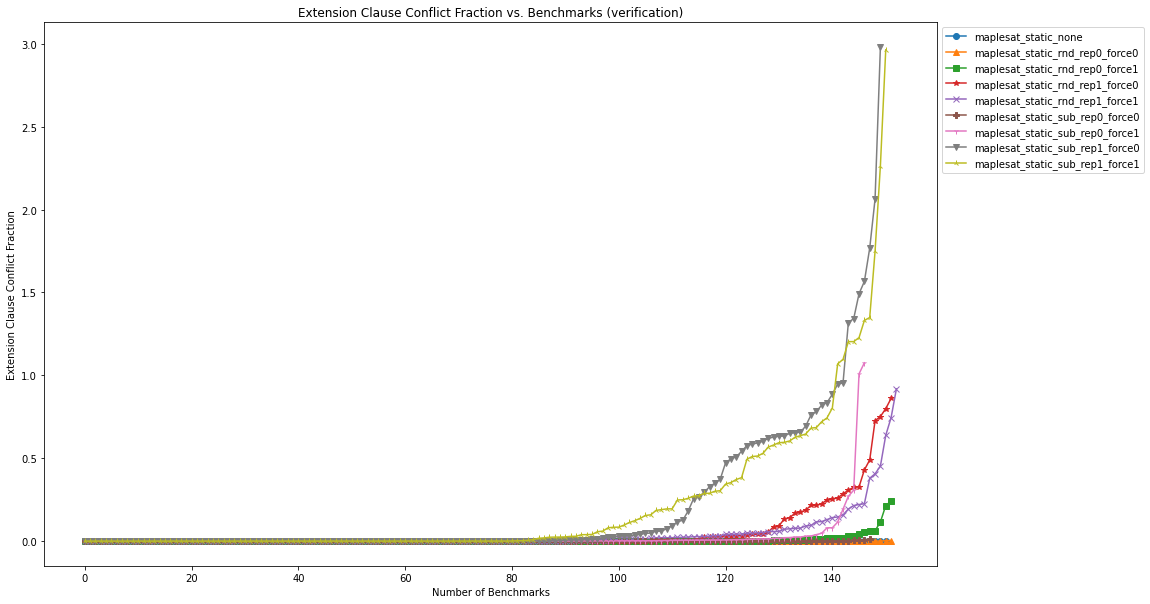

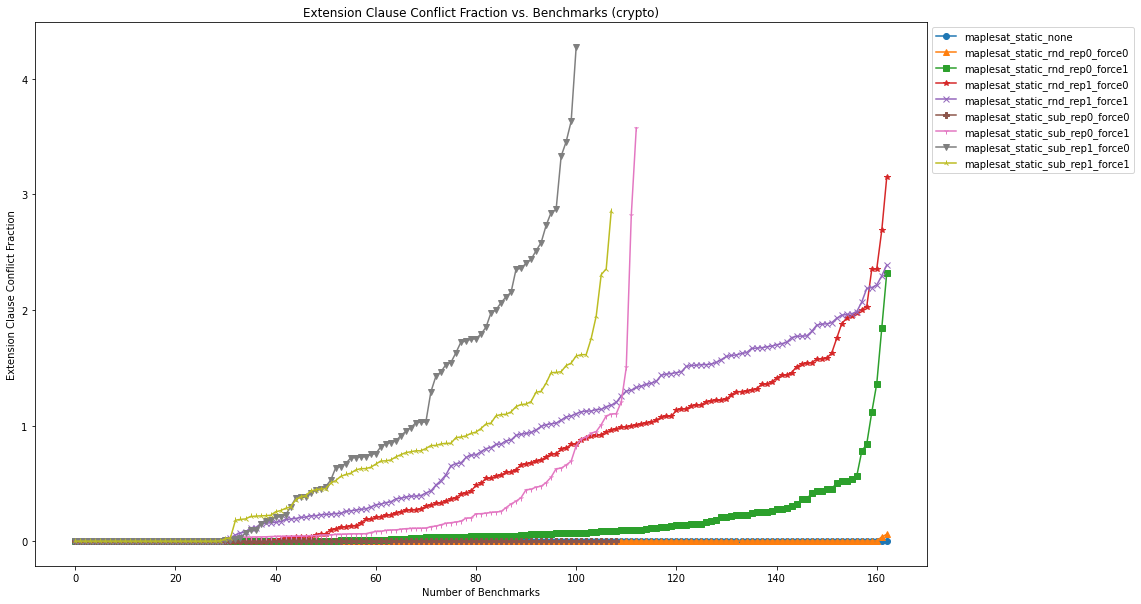

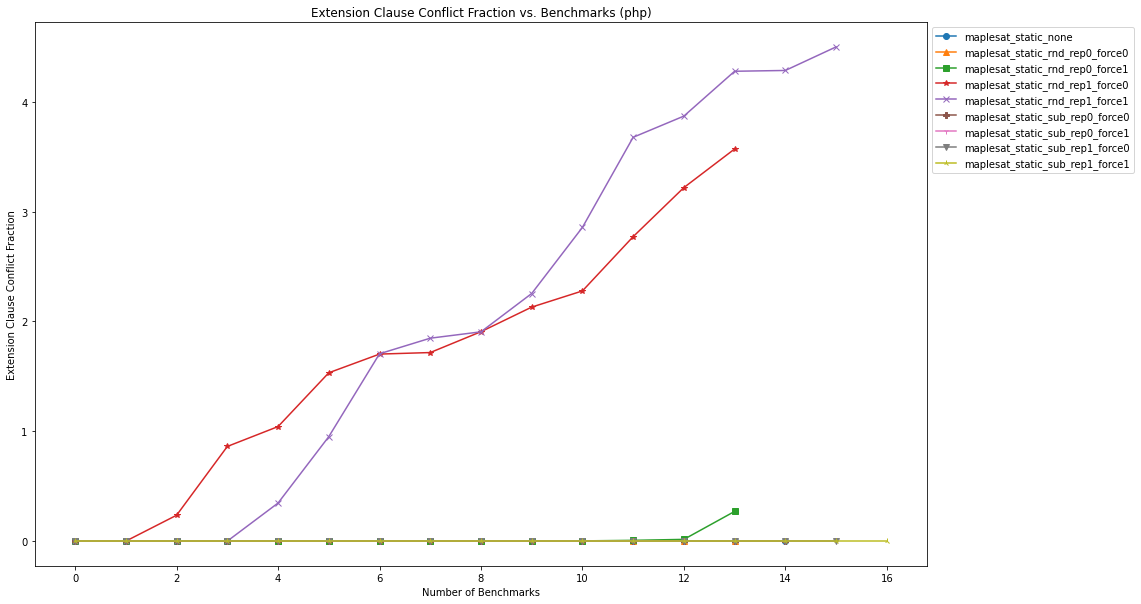

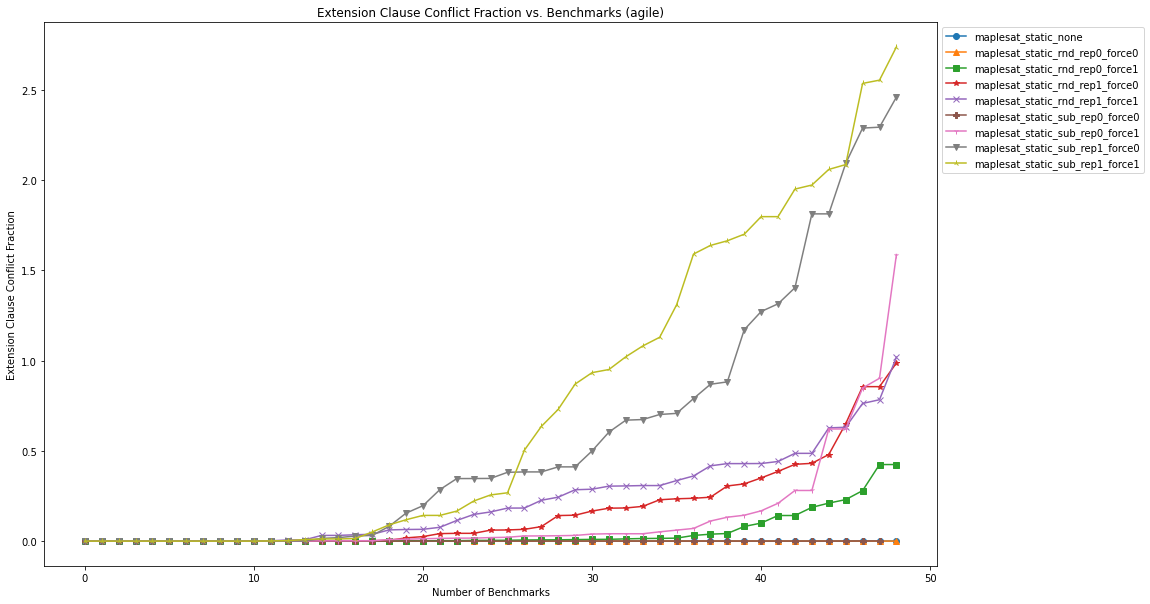

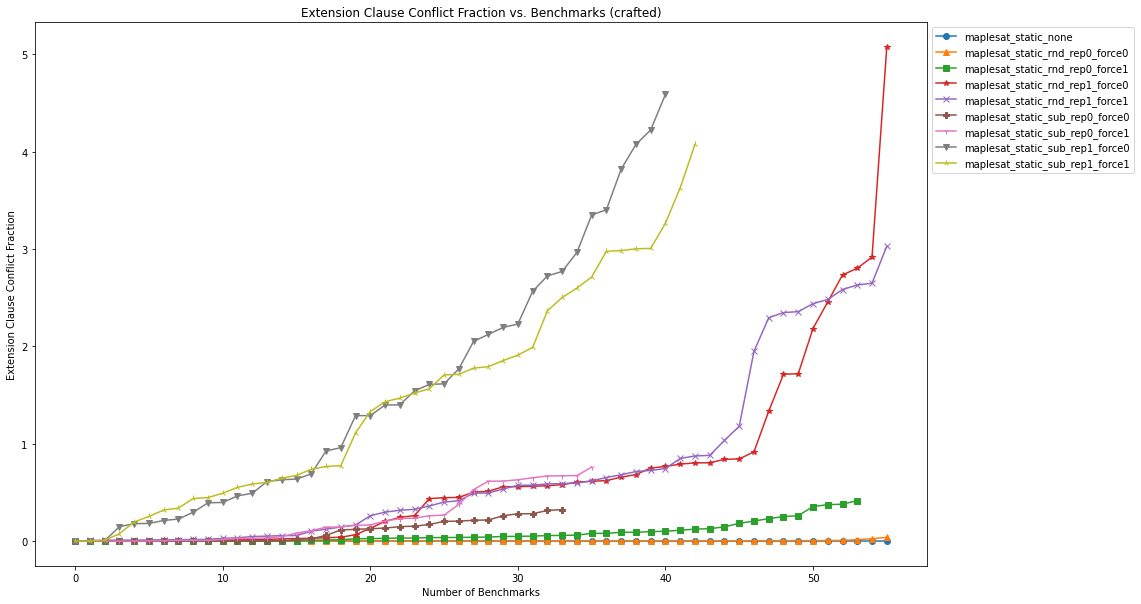

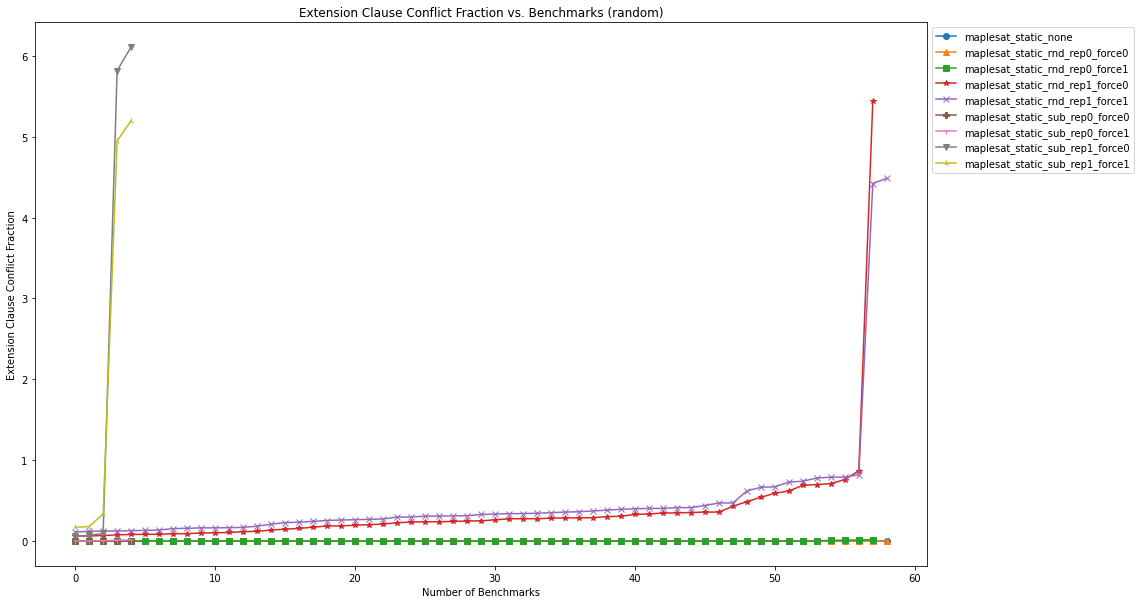

In [16]:
cactusByVariant(solvers, 'ev_conf_frac', 'Extension Clause Conflict Fraction', False)